# DCGAN to generate synthetic human faces using keras and CNN.
# 256 images used to train the GAN. Latent space of 128 dimension used.

In [2]:
################################################################################################################################
# import required libraries tensorflow, keras, numpy, matplotlib etc.
################################################################################################################################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
from IPython import display

In [3]:
################################################################################################################################
# get the face images from local directory(which were dowloaded from google site) 
################################################################################################################################
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan256", label_mode=None, image_size=(128, 128), batch_size=2
)
dataset = dataset.map(lambda x: x / 255)

Found 256 files belonging to 1 classes.


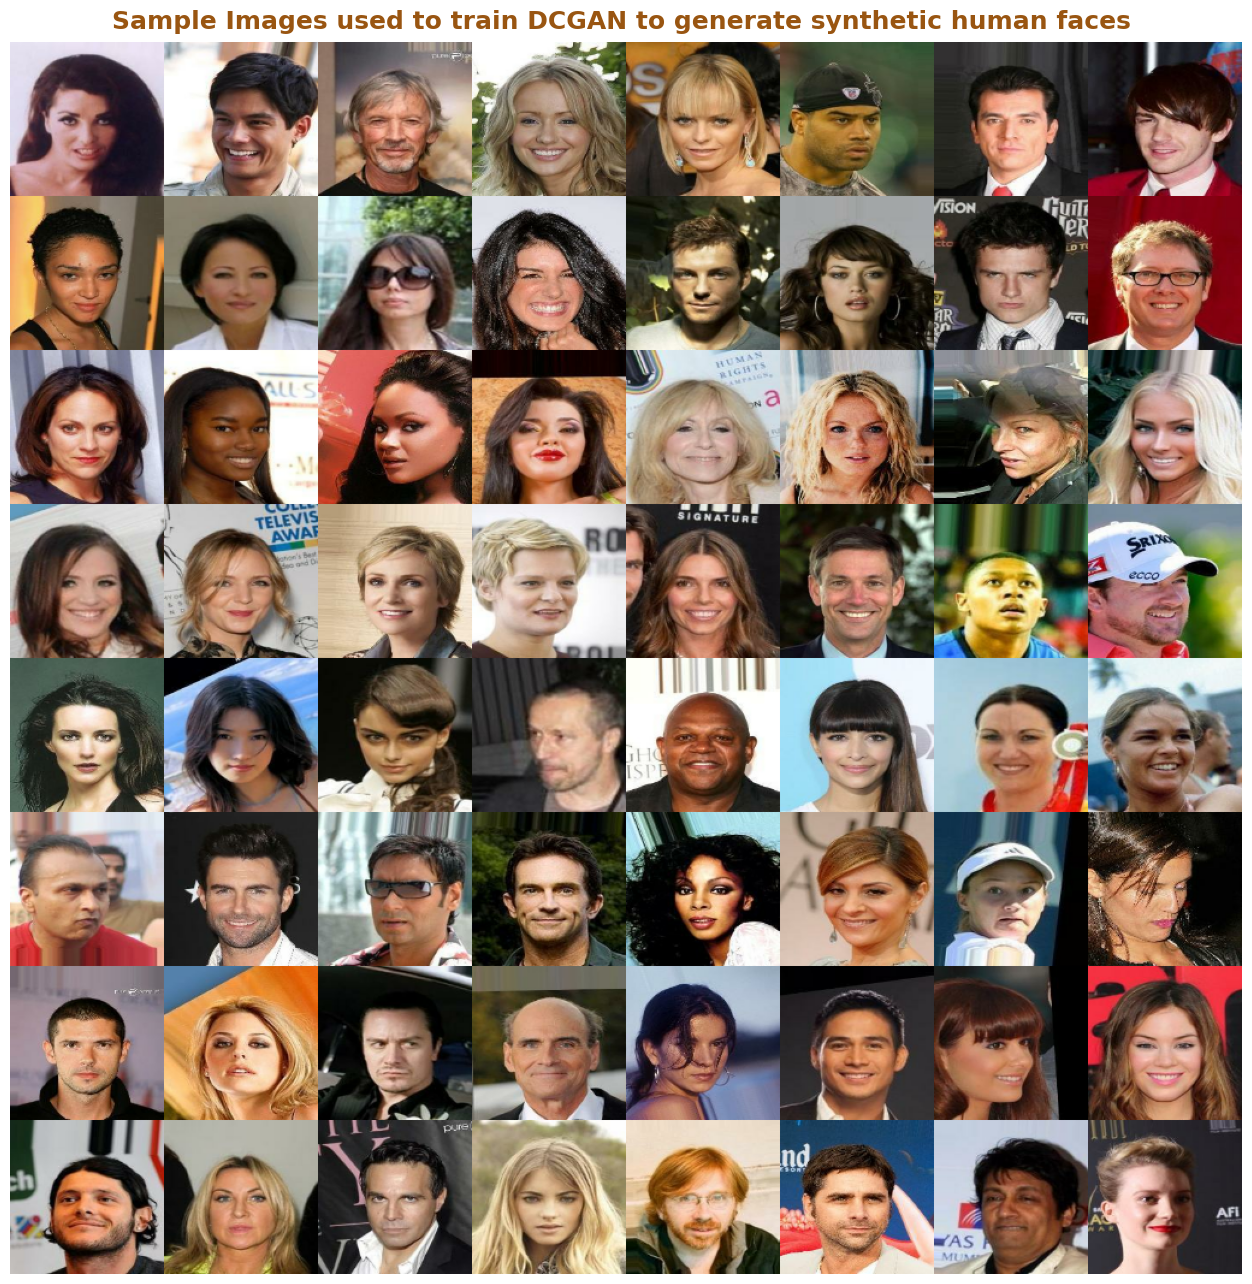

In [4]:
################################################################################################################################
# plot 64 out of 256 used for training
################################################################################################################################

i=0
j=0
plt.figure(figsize=(16,16))
for img in dataset:   
    
    if j==8:
        j=0
        i+=1    
        
    if ((i == 0) & (j==4)):
        plt.title("Sample Images used to train DCGAN to generate synthetic human faces ", fontsize=18,va='bottom',color='#995511',fontweight='bold')

    image      = ((img[0].numpy()*255).astype('int32'))     
    
    plt.axis('off')
    globals()['output%s' % j] = image
    if j==7:
        globals()['outputv%s' % i] = np.hstack([output0,output1,output2,output3,output4,output5,output6,output7])
    
    if ((i==7) and (j==7)):
        output=np.vstack([outputv0,outputv1,outputv2,outputv3,outputv4,outputv5,outputv6,outputv7])
        plt.imshow(output,aspect=1)  
        plt.show()
        break
    j+=1


In [5]:
################################################################################################################################
# define sequential generator with layers, activation, kernel size, strides, padding and latent space dimension
################################################################################################################################
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),        
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 256)       10

In [6]:
################################################################################################################################
# define sequential discriminator with input shape, kernel size, strides, padding, activation functions etc.
################################################################################################################################
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)       

In [7]:
################################################################################################################################
# define GAN joining together gererator and discriminator, defining loss functions, optimizers and metrics for both.
# also define the training step function
################################################################################################################################
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
################################################################################################################################
# Training function with these steps for every batch.
# 1. generate Sample random points in the latent space, 
# 2. then generate fake iamges out of latent space. 
# 3. concatenate (real) images used for training and the generated (fake) images.
# 4. create and concatenate labels for real and fake images (0 for real and 1 for fake)
# 5. Add random noise to the labels - important trick!
# 6. then train the discriminator first updating the gradients for trainable variables
################################################################################################################################

    def train_step(self, real_images):
        
        batch_size            = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images      = self.generator(random_latent_vectors)
        combined_images       = tf.concat([generated_images, real_images], axis=0)
        labels                = tf.concat([np.ones((2, 1)), np.zeros((2, 1))], axis=0 )
                
        labels                = tf.cast(labels,dtype=tf.float32)
        labels               += 0.05 * tf.random.uniform(tf.shape(labels))
################################################################################################################################        
# train discriminator with binary cross entropy loss function using combined real and fake images and respective labels
# using adam optimizer
################################################################################################################################
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        
################################################################################################################################
# train the generator here. update weights only for generator. No weights upadate for disctiminator as we already done.
# Assemble labels that say "all real images"
################################################################################################################################
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = np.zeros((2, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
################################################################################################################################
# Update metrics from geneartor and discriminator and send it back throgh return statement.
################################################################################################################################
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    

In [11]:
################################################################################################################################
# define a callback function that would save the weights to load as and when required, and also a function to plot the images
# and save them as png
################################################################################################################################
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(16, self.latent_dim),mean=0.2,stddev=0.4)
        generated_images = self.model.generator(random_latent_vectors)
        display.clear_output(wait=True)
        fig = plt.figure(figsize=(4, 4))
        for i in range(4 * 4):
            plt.subplot(4, 4, 1 + i)
            plt.axis('off') 
            img= generated_images[i]        
            img=((img+1)/2)        
            plt.imshow(img)
        
        filename = './output128_comb/generated_plot_e%04d.png' % (epoch+1)
        plt.savefig(filename)
        plt.show()
        
        generator.save('./weights/generator_celeb128.h5')
        discriminator.save('./weights/discriminator_celeb128.h5')

In [9]:
################################################################################################################################
# compile geneartor, discriminator and GAN. and also load the saved weights for generator and discriminator if available
################################################################################################################################
generator.load_weights('./weights/generator_celeb128.h5')
discriminator.load_weights('./weights/discriminator_celeb128.h5')

generator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
)
discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


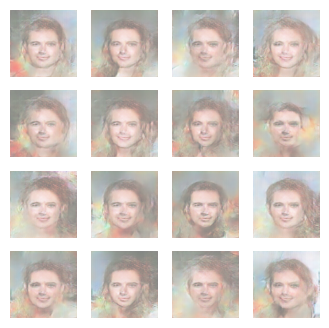

In [12]:
################################################################################################################################
# this is the training cell. train for 150 epochs first, and based on the results train more if required
################################################################################################################################
epochs = 1
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(latent_dim=latent_dim)])


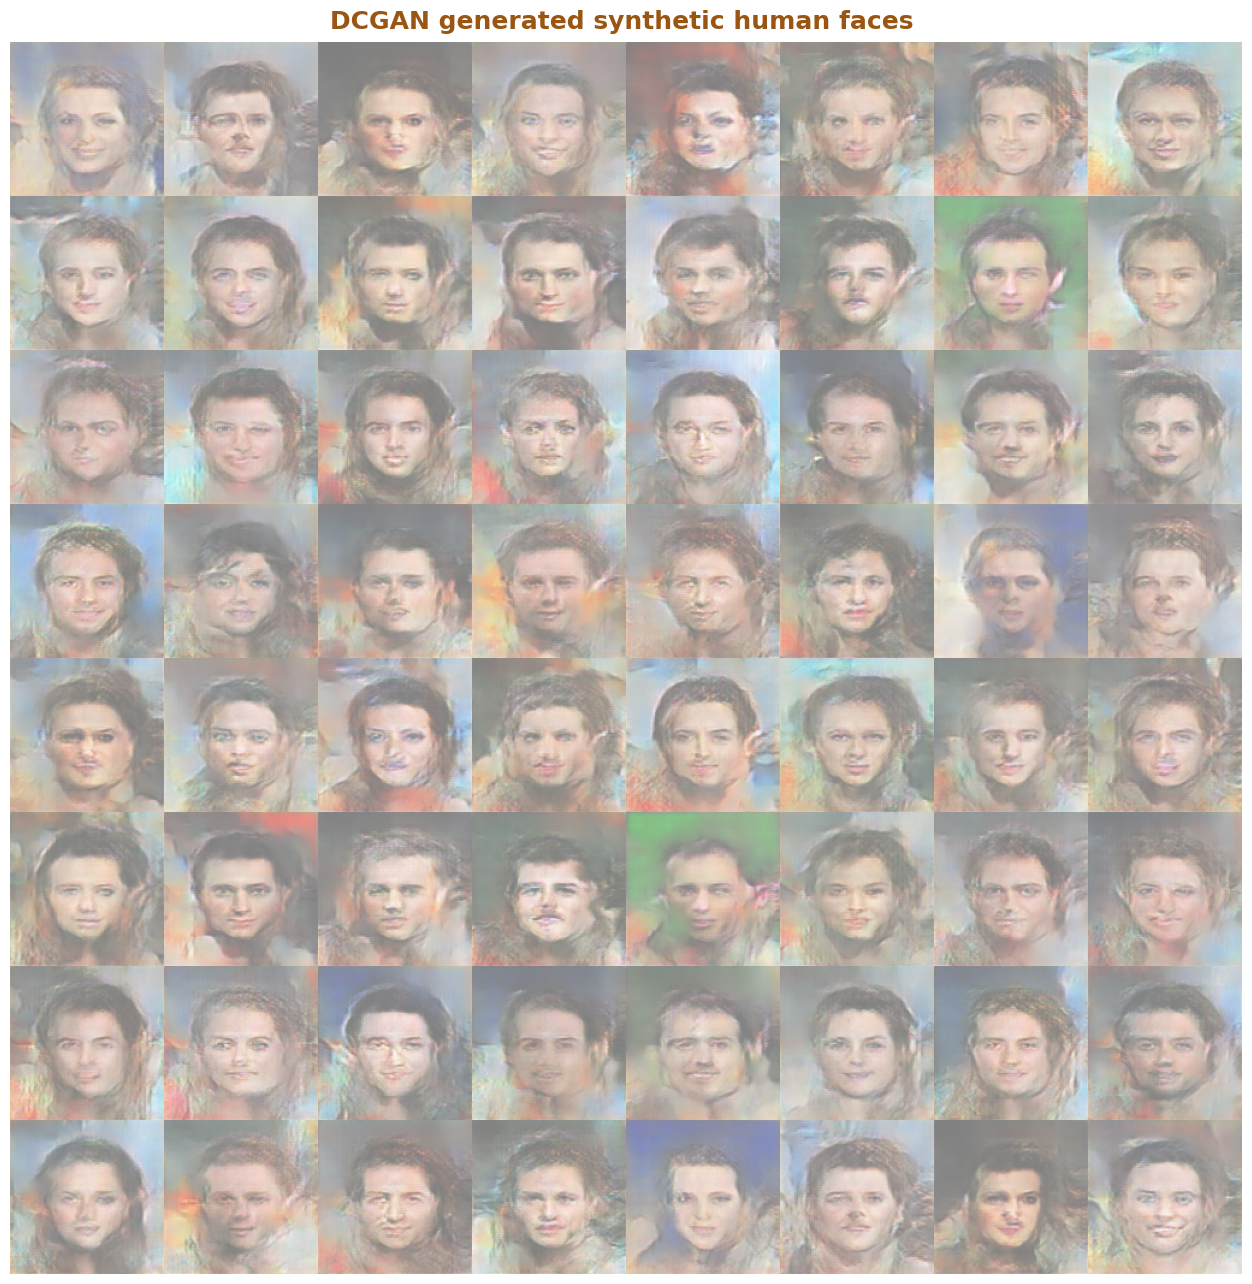

In [17]:
################################################################################################################################
# plot the generated images once satisfied with the results.
################################################################################################################################
a=0
plt.figure(figsize=(16,16))
for i in range(8):
    for j in range(8):
        if ((i == 0) & (j==5)):
            plt.title("DCGAN generated synthetic human faces ", fontsize=18,va='bottom',color='#995511',fontweight='bold')
        
         
        generator.load_weights('./weights/generator_celeb_e%04d.h5' %(a+1))
        random_latent_vectors=tf.random.normal(shape=(1, latent_dim),mean=0.45,stddev=0.4)
        
        generated_images = generator(random_latent_vectors)
        image      = ((generated_images[0]+1)/2)     
        a+=1
        if a==30:
            a=0
        plt.axis('off')
        globals()['output%s' % j] = image
        
    globals()['outputv%s' % i] = np.hstack([output0,output1,output2,output3,output4,output5,output6,output7])
    

output=np.vstack([outputv0,outputv1,outputv2,outputv3,outputv4,outputv5,outputv6,outputv7])

plt.imshow(output,aspect=1)  
plt.show()
